In [1]:
!pip install transformers tokenizers evaluate huggingface_hub --quiet

import numpy as np
# from huggingface_hub import notebook_login
# notebook_login()

# Loading Model and Tokenizer

In [2]:
from transformers import TFAutoModelForSequenceClassification, PreTrainedTokenizerFast
import datasets

tokenizer = PreTrainedTokenizerFast.from_pretrained('raygx/GPT2-Nepali-Casual-LM')
tokenizer

PreTrainedTokenizerFast(name_or_path='raygx/GPT2-Nepali-Casual-LM', vocab_size=50000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'pad_token': '[PAD]'}, clean_up_tokenization_spaces=True)

In [3]:
from transformers import AutoConfig
from transformers import BertTokenizerFast

# print("Loading Model 'distilgpt2")
# using = 'gpt'
# model = TFAutoModelForSequenceClassification.from_pretrained('distilgpt2',
#                                     bos_token_id=tokenizer.bos_token_id,
#                                     eos_token_id=tokenizer.eos_token_id,
#                                     pad_token_id=tokenizer.pad_token_id,
#                                     id2label={0:"NEUTRAL",1:"POSITIVE",2:"NEGATIVE"},
#                                     label2id={"NEUTRAL":0,"POSITIVE":1,"NEGATIVE":2})

  
print("Loading Model 'distilbert-base-uncased")
using = 'bert'
model = TFAutoModelForSequenceClassification.from_config(
    AutoConfig.from_pretrained(
        'distilbert-base-uncased',
        bos_token_id=tokenizer.bos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
        id2label={0:"NEUTRAL",1:"POSITIVE",2:"NEGATIVE"},
        label2id={"NEUTRAL":0,"POSITIVE":1,"NEGATIVE":2}
      )
    )

if using == 'bert':
  tokenizer = BertTokenizerFast.from_pretrained("raygx/GPT2-Nepali-Casual-LM")
  
model.resize_token_embeddings(len(tokenizer))
print(model.config)
print(model.summary())

Loading Model 'distilbert-base-uncased


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'PreTrainedTokenizerFast'. 
The class this function is called from is 'BertTokenizerFast'.


DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "dim": 768,
  "dropout": 0.1,
  "eos_token_id": 2,
  "hidden_dim": 3072,
  "id2label": {
    "0": "NEUTRAL",
    "1": "POSITIVE",
    "2": "NEGATIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 2,
    "NEUTRAL": 0,
    "POSITIVE": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 3,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.29.2",
  "vocab_size": 50000
}

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 81321984  
 nLayer)

In [4]:
from transformers import create_optimizer, AdamWeightDecay
import tensorflow as tf

optimizer = AdamWeightDecay(learning_rate=9e-6, weight_decay_rate=0.009)
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


# Data Loading and Preparation

In [5]:
data = datasets.load_dataset("raygx/NepCov19Tweets")
data = data.rename_columns({"Sentiment":"labels","Sentences":"text"})
data

  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 33471
    })
})

In [6]:
data = data.shuffle(999)
data = data['train'].train_test_split(test_size=0.2)
data

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 26776
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 6695
    })
})

In [7]:
def prepareLabels(row):
    if row['labels'] == -1:
        row['labels'] = 2
        
    return row

data = data.map(
        prepareLabels,
        num_proc=4)

print(data)

Map (num_proc=4):   0%|          | 0/26776 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/6695 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 26776
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 6695
    })
})


In [8]:
%%time

def preprocess_function(rows):
    return tokenizer(rows['text'],truncation=True)

print("Tokenizing the data")
tokenized_inputs = data.map(
    preprocess_function,
    batched=True,
    num_proc=2,
    remove_columns=data["train"].column_names,
)
tokenized_inputs = tokenized_inputs.remove_columns(['token_type_ids'])

tokenized_inputs['train'] = tokenized_inputs['train'].add_column(
    name="labels",column=data['train']['labels']
)
tokenized_inputs['test'] = tokenized_inputs['test'].add_column(
    name="labels",column=data['test']['labels']
)

tokenized_inputs

Tokenizing the data


Map (num_proc=2):   0%|          | 0/26776 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map (num_proc=2):   0%|          | 0/6695 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


CPU times: user 328 ms, sys: 287 ms, total: 615 ms
Wall time: 4.43 s


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 26776
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6695
    })
})

In [9]:
print(data['train'][:1])
print(tokenized_inputs['train'][:1]['input_ids'])
print(tokenizer.batch_decode(tokenized_inputs['train'][:1]['input_ids']))

{'labels': [2], 'text': ['कोरोना भाइरस कोभिड महामारी लामो समयसम्म रहने विश्व स्वास्थ्य सङ्गठनका प्रमुखको चेतावनी']}
[[3804, 4907, 1752, 8504, 1484, 5397, 2024, 695, 1004, 28270, 9358, 4887]]
['कोरोना भाइरस कोभिड महामारी लामो समयसम्म रहने विश्व स्वास्थ्य सङ्गठनका प्रमुखको चेतावनी']


In [10]:
from transformers import DataCollatorWithPadding

print("Initializing Data Collator")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, 
                                        max_length=128,
                                        return_tensors="tf")

Initializing Data Collator


In [11]:
print("Preparing Training and Testing sets to TRAIN the MODEL")
tf_train_set = model.prepare_tf_dataset(
    tokenized_inputs["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized_inputs["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Preparing Training and Testing sets to TRAIN the MODEL


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


# Training and Evaluation

## Training **Batch 1**

In [12]:
%%time

n_epoch = 3
print("Training the model")
history = model.fit(x=tf_train_set, 
          validation_data=tf_test_set,
          epochs=n_epoch)
print(history.history)

Training the model
Epoch 1/3
1673/1673 [==============================] - 217s 123ms/step - loss: 0.8340 - val_loss: 0.7437
Epoch 2/3
1673/1673 [==============================] - 202s 121ms/step - loss: 0.6646 - val_loss: 0.6993
Epoch 3/3
1673/1673 [==============================] - 209s 125ms/step - loss: 0.5537 - val_loss: 0.6964
{'loss': [0.8340355157852173, 0.6645979881286621, 0.5537247061729431], 'val_loss': [0.7437053918838501, 0.6993195414543152, 0.6963699460029602]}
CPU times: user 8min 29s, sys: 21.4 s, total: 8min 50s
Wall time: 12min 18s


<Axes: >

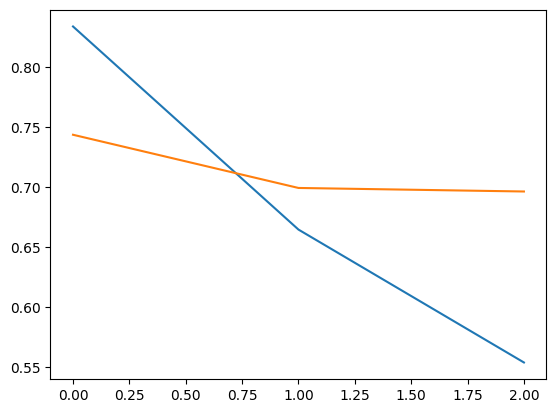

In [13]:
import seaborn

seaborn.lineplot(history.history['loss'])
seaborn.lineplot(history.history['val_loss'])

### Evaluation

In [14]:
%%time
from transformers import pipeline, TextClassificationPipeline

if using=='gpt':
  print("Getting Test Prediction")
  pipe = pipeline('sentiment-analysis',model=model,tokenizer=tokenizer)
  prediction = pipe(data['test']['text'])

  print("Prediction Label to Id")
  pred_labels = [model.config.label2id[x['label']] for x in prediction]
else:  
  print("Getting Test Prediction")
  pred_labels = [np.argmax(tf.nn.softmax(model(tf.constant(x)).logits)) for x in tokenized_inputs['test']['input_ids']]

actual_labels = data['test']['labels']

Getting Test Prediction
CPU times: user 12min 17s, sys: 2.92 s, total: 12min 20s
Wall time: 12min 22s


**Computing F1-Score, Precision, Recall and Accuracy of the Model**

In [15]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

print("F1-Score",f1_score(actual_labels,pred_labels,average='weighted'))
print("Precision-Score",precision_score(actual_labels,pred_labels,average='weighted'))
print("Recall-Score",recall_score(actual_labels,pred_labels,average='weighted'))
print("accuracy_Score",accuracy_score(actual_labels,pred_labels))

F1-Score 0.7052822479528149
Precision-Score 0.7022452053736112
Recall-Score 0.7093353248693055
accuracy_Score 0.7093353248693055


**Plotting Confusion Matrix**

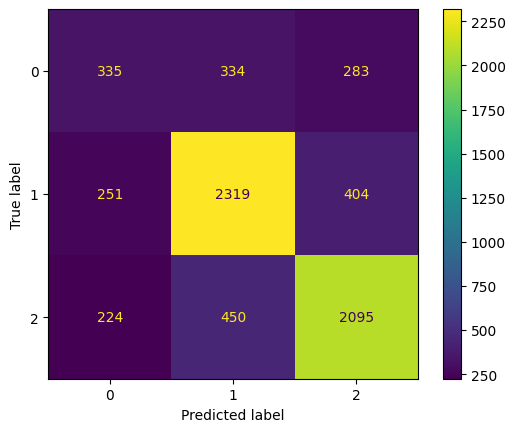

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(actual_labels,pred_labels,num_classes=3).numpy())
cmd.plot()

**Pushing Model to Huggingface Hub**

In [ ]:
### Pushing Model to hub
# model.push_to_hub("raygx/GPT2-NepSA-T1",commit_message="Training From Scratch:Distilgpt2;3L6H:Batch 1:Epoch 10",)

## Training **Batch 2**

In [ ]:
%%time
n_epoch = 5 # I've actually run this twice, so it is 10 epochs
print("Training the model")
history = model.fit(x=tf_train_set, 
          validation_data=tf_test_set,
          epochs=n_epoch)
print(history.history)

In [ ]:
import seaborn

seaborn.lineplot(history.history['loss'])
seaborn.lineplot(history.history['val_loss'])

### Evaluation

In [ ]:
%%time
from transformers import pipeline, TextClassificationPipeline

if using=='gpt':
  print("Getting Test Prediction")
  pipe = pipeline('sentiment-analysis',model=model,tokenizer=tokenizer)
  prediction = pipe(data['test']['text'])

  print("Prediction Label to Id")
  pred_labels = [model.config.label2id[x['label']] for x in prediction]
else:  
  print("Getting Test Prediction")
  pred_labels = [np.argmax(tf.nn.softmax(model(tf.constant(x)).logits)) for x in tokenized_inputs['test']['input_ids']]

actual_labels = data['test']['labels']

**Computing F1-Score, Precision, Recall and Accuracy of the Model**

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

print("F1-Score",f1_score(actual_labels,pred_labels,average='weighted'))
print("Precision-Score",precision_score(actual_labels,pred_labels,average='weighted'))
print("Recall-Score",recall_score(actual_labels,pred_labels,average='weighted'))
print("accuracy_Score",accuracy_score(actual_labels,pred_labels))

**Plotting Confusion Matrix**

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(actual_labels,pred_labels,num_classes=3).numpy())
cmd.plot()

**Pushing Model to Huggingface Hub**

In [ ]:
# tokenizer.push_to_hub("raygx/GPT2-NepSA-T1")

In [ ]:
### Pushing Model to hub
# model.push_to_hub("raygx/GPT2-NepSA-T1",commit_message="Training From Scratch:Distilgpt2;3L6H:Batch 2:Epoch 5")